In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib ipympl

In [2]:
# Main system parameters: number of mics, number of samples in time
Nmics = 64
Nsamp = 100


In [3]:
# Source: x,y coordinates: x: 0+, y: [-Y, +Y] where Y determined by pitch and Nmics
src = (0, 0)
# Spacing between microphones
pitch = 0.1
# Proxy for Sampling Rate, Distance covered by sound in the Sampling Time at a given velocity
dist_per_sample = 0.1
# Speed of Sound in the medium
C = 0.5
# Time dilation factor for sinc pulse: how narrow
SincP = 0.5

# Locations of the microphones
mics = []
# If the number of microphones is even, then the center microphone should be offset by half of the microphone pitch.
dist_from_origin = 0
if (Nmics%2 == 0):
    dist_from_origin = pitch/2

# Create a NumPy array of zeros to store the X-coordinates of the microphones.
Xmics = np.zeros(Nmics)
# Create a NumPy array of linspace values to store the Y-coordinates of the microphones.
Ymics = np.linspace((-Nmics//2) * pitch + dist_from_origin, (Nmics//2) * pitch - dist_from_origin, Nmics)

# Create a list of microphone locations by zipping the X- and Y-coordinates together.
mics = list(zip(Xmics, Ymics))

# Location of point obstacle
obstacle = (3, -1)

In [4]:
# Source sound wave - time axis and wave
# sinc wave with narrowness determined by parameter
# Define a function to generate the source signal.
def wsrc(t):
    # Generate a sinc function with the specified peak frequency.
    return np.sinc(SincP*t)

In [5]:

# Calculate the sampling time based on the distance per sample and the speed of sound.
sampling_time = dist_per_sample/C
# Create a NumPy array of time samples ranging from zero to Nsamp * sampling_time, with sampling_time steps.
time_samples = np.arange(0, Nsamp * sampling_time, sampling_time)
# Create a NumPy array of distance samples ranging from zero to Nsamp * dist_per_sample, with dist_per_sample steps.
distance_samples = np.arange(0, Nsamp * dist_per_sample, dist_per_sample)
# Generate the source waveform.
src_wave = wsrc(time_samples)

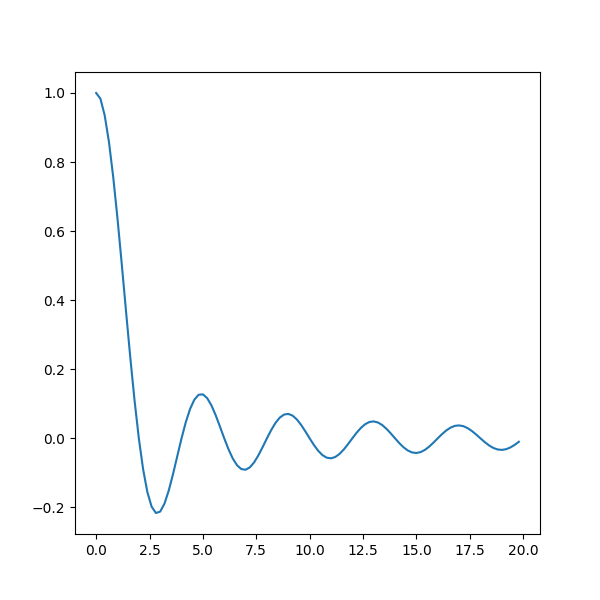

In [6]:
fig, ax2 = plt.subplots(1, 1, figsize=(6, 6))
ax2.plot(time_samples, src_wave)
plt.show()

In [7]:
def pointDistance(pt1, pt2):
    return np.sqrt((pt1[0] - pt2[0])**2 + (pt1[1] - pt2[1])**2)

In [8]:
# Distance from src to a mic after reflecting through pt
def dist(src, pt, mic):
    d1 = pointDistance(src, pt)
    d2 = pointDistance(pt, mic)
    return d1 + d2

Finding the delay for each microphone

In [9]:
# Define a function to calculate the delay for each microphone.
def delayPerMic(src, pt, micArray):
    """Calculates the delay for each microphone given the source location, point location, and microphone array.

    Args:
        src: The source location as a tuple (x, y).
        pt: The point location as a tuple (x, y).
        micArray: A list of microphone locations as tuples (x, y).

    Returns:
        A list of delays for each microphone.
    """

    micDelay = [0 for _ in range(Nmics)]
    for i in range(Nmics):
        micDelay[i] = dist(src, pt, micArray[i])/C

    return micDelay

In [10]:
# Calculate the delay for each microphone at the obstacle location.
micDelay = delayPerMic(src, obstacle, mics)

### Received Signals by the Microphones

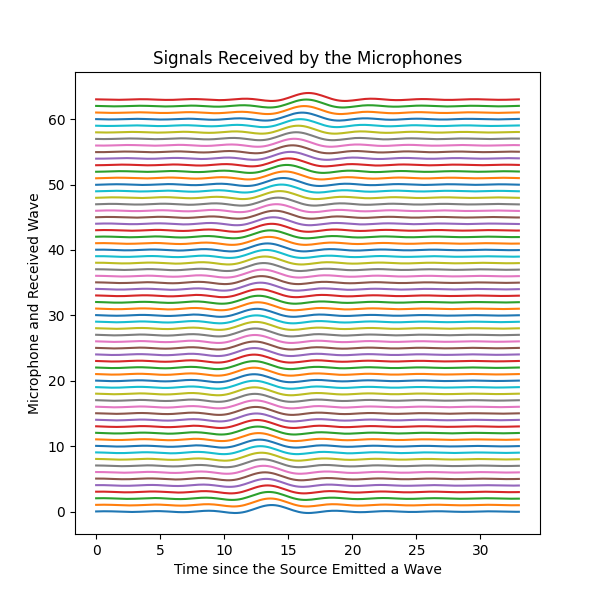

In [11]:
verticalShift = 1
# Shift the source signal by the delay for each microphone.
yMicVals = []
yPadding = []
fig, ax1 = plt.subplots(1, figsize=(6, 6))
ax1.set_title("Signals Received by the Microphones")
ax1.set_ylabel("Microphone and Received Wave")
ax1.set_xlabel("Time since the Source Emitted a Wave")
xMic = []
for i in range(Nmics):
    """Shifts the source signal by the delay for the current microphone and plots the shifted signal on the graph.

    Args:
        i: The index of the current microphone.
    """

    xMic = np.concatenate((time_samples,np.arange(Nsamp * sampling_time, 2 * max(micDelay), sampling_time)))
    # Does not really shift the source signal but it shifts the origin of time to the time delay and realizes the values of the function
    yMic = wsrc(xMic - micDelay[i])
    yMicVals.append(yMic)

    # Plot the shifted signal.
    ax1.plot(xMic, yMic + verticalShift * i)

# Show the graph.
plt.show()

### Delay and Sum Algorithm 
- It is not advised to be recreating to Nsamp because it could cause a heavily delayed output from a microphone to be unaccounted for.
- A good rule of thumb is to choose an upper limit for the time axis that is at least twice the duration of the signal of interest.
- In this case recreating till Nsamp plus the once or twice the maximum delay would work.

In [18]:
# Create a list of empty lists to store the beamformed output for each distance sample.
X = [[] for _ in distance_samples]

# Iterate over all distance samples.
for i in range(len(distance_samples)):
    # Get the current distance sample.
    xi = distance_samples[i]

    # Iterate over all microphone locations.
    for j in Ymics:
        # Initialize the amplitude at the current distance sample and microphone location.
        ampAtPt = 0

        # Calculate the delay for each microphone at the current distance sample and microphone location.
        micDelayByPt = delayPerMic(src, (xi, j), mics)

        # Iterate over all microphones.
        for k in range(Nmics):
            # Check if the delay for the current microphone is less than or equal to the last time sample.
            if micDelayByPt[k] <= xMic[-1]:
                # Find the index of the time sample in `time_samples` that is closest to the delayed version of the source signal from the current microphone.
                timeIndex = np.where(abs(xMic - micDelayByPt[k]) <= sampling_time)[0][0]

                # Add the delayed version of the source signal from the current microphone to the amplitude `ampAtPt`.
                ampAtPt += yMicVals[k][timeIndex]

        # Append the amplitude `ampAtPt` to the list `X[i]`.
        X[i].append(ampAtPt)


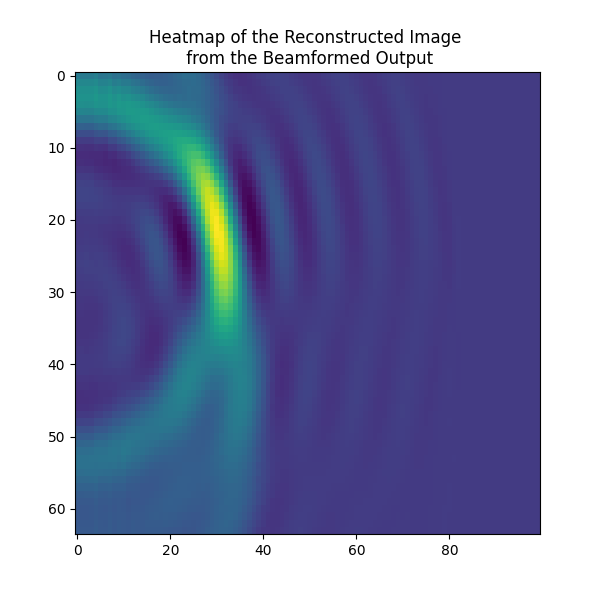

In [19]:
# Plot the beamformed output as a heatmap
fig, ax = plt.subplots(1, figsize=(6, 6))
ax.set_title("Heatmap of the Reconstructed Image \n from the Beamformed Output")
ax.imshow(np.transpose(X), aspect='auto')

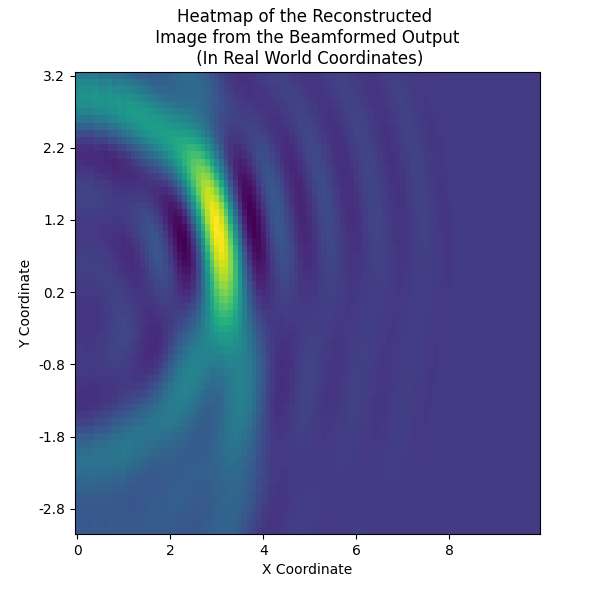

In [20]:
# Plot the beamformed output as a heatmap and scaling the axes to represent real world co-ordinates
fig, ax3 = plt.subplots(1, figsize=(6, 6))
ax3.set_title("Heatmap of the Reconstructed \n Image from the Beamformed Output \n (In Real World Coordinates)")
ax3.set_ylabel("Y Coordinate")
ax3.set_xlabel("X Coordinate")

# Set the y-axis ticks to be scaled versions of the full range of the y-axis values, so that the shifted signals plots represent real world coordinates.
ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(-1 * (x - Nmics/2)*pitch))
ax3.yaxis.set_major_formatter(ticks_y)

# Set the x-axis ticks to be scaled versions of the full range of the x-axis values, so that the shifted signals plots represent real world coordinates.
ticks_x = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x*dist_per_sample))
ax3.xaxis.set_major_formatter(ticks_x)

ax3.imshow(np.transpose(X), aspect='auto')

## Questions
- The (x, y) coordinates corresponding to the maximum amplitude (yellowcolour) is approximately (30, 22). Explain why this is the correct expected position for the given obstacle.

Since the distance between samples is 0.1, 30 on the x-axis means that it is 30 distance samples away from the source along the horizontal which implies that it is $30 \times 0.1 = 3$ units away. The 22 on the y axis says that it is at the same vertical level as  the $22^{nd}$ microphone from the bottom, which is the $32 - 22 = 10^{th}$ microphone from the source downwards. As the distance between each microphone is `pitch` = 0.1, the distance of the $10^{th}$ microphone from the origin is $10 \times 0.1 = 1$ units downward, i.e., -1 along the y-axis. So (30, 22) is (3, -1) in real world coordinates which is the position of obstacle.

- What is the maximum obstacle x- and y- coordinate that you can use and still have an image
reconstructed?

The maximum x - coordinate that can be used would be half of $N_{samp}$ $\times$ distance_between_samples + the distance travelled by the sample in time taken for the maximum microphone delay. This is because only when the wave gets reflected and comes back can it be detected by the microphones and its posisiton be estimated, hence half of the maximum distance travelable. The maximum y - coordinate, or rather, the maximum vertical distance from the source that can produce a clear reconstructed image would be, roughly as a rule of thumb, half the distance of the farthest microphone from the source, which in the case of $N_{mics} = 64$ is 1.575. It is important to note that this is just the maximum y coordinate that can be used. In practice, you may be able to reconstruct images with larger y coordinates. However, the quality of the reconstructed image will decrease as the y coordinate increases.

- What happens if C is different - if C is decreased it looks like the image becomes sharper. Can you
explain why intuitively?

When the speed of sound is lower, the sound wave from the source will arrive at the different microphones in the array at more similar times. This allows the beamforming algorithm to better focus on the source of the sound wave and produce a sharper image.


- What happens if Nmics is increased or decreased? Do the experiments with Nmics = [8, 32, 64]
and Nsamp = [50, 100, 200] (all combinations). Attach the resulting images.

When Nmics is increased or decreased the ability to estimate the y coordinate of the obstacle increases or increases. This is because the fewer the mics, the lower your vertical range is.